In [1]:
import keras
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential,Model
from keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
import scipy as sp

In [2]:
# load the Fashion MNIST dataset
(X_train,Y_train),(X_test,Y_test)  = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
# Put an additional axis for the channels of the image.
# Fashion MNIST is grayscale so we place 1 at the end. Other datasets
# will need 3 if it's in RGB.
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

# Normalize the pixel values from 0 to 1
X_train = X_train/255
X_test  = X_test/255

# Cast to float
X_train = X_train.astype('float')
X_test  = X_test.astype('float')

In [4]:
def show_img(img):
    '''utility function for reshaping and displaying an image'''

    # convert to float array if img is not yet preprocessed
    img  = np.array(img,dtype='float')

    # remove channel dimension
    img = img.reshape((28,28))

    # display image
    plt.imshow(img)

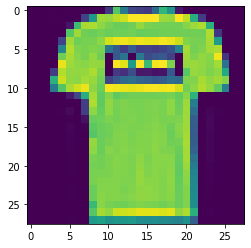

In [5]:
show_img(X_train[1])

In [6]:
# use the Sequential API
model = Sequential()

# notice the padding parameter to recover the lost border pixels when doing the convolution
model.add(Conv2D(16,input_shape=(28,28,1),kernel_size=(3,3),activation='relu',padding='same'))
# pooling layer with a stride of 2 will reduce the image dimensions by half
model.add(MaxPooling2D(pool_size=(2,2)))

# pass through more convolutions with increasing filters
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))

# use global average pooling to take into account lesser intensity pixels
model.add(GlobalAveragePooling2D())

# output class probabilities
model.add(Dense(10,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0

In [7]:
# configure the training
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

# train the model. just run a few epochs for this test run. you can adjust later.
model.fit(X_train,Y_train,batch_size=32, epochs=5, validation_split=0.1, shuffle=True)

Epoch 1/5
1688/1688 [==============================] - 26s 6ms/step - loss: 0.6018 - accuracy: 0.7778 - val_loss: 0.4056 - val_accuracy: 0.8543
Epoch 2/5
1688/1688 [==============================] - 10s 6ms/step - loss: 0.3717 - accuracy: 0.8641 - val_loss: 0.3199 - val_accuracy: 0.8810
Epoch 3/5
1688/1688 [==============================] - 10s 6ms/step - loss: 0.3097 - accuracy: 0.8874 - val_loss: 0.2956 - val_accuracy: 0.8898
Epoch 4/5
1688/1688 [==============================] - 10s 6ms/step - loss: 0.2732 - accuracy: 0.9003 - val_loss: 0.3004 - val_accuracy: 0.8832
Epoch 5/5
1688/1688 [==============================] - 11s 7ms/step - loss: 0.2482 - accuracy: 0.9097 - val_loss: 0.2735 - val_accuracy: 0.8993


In [8]:
model.layers[-3].output

<KerasTensor: shape=(None, 3, 3, 128) dtype=float32 (created by layer 'conv2d_3')>

In [9]:
cam_model  = Model(inputs=model.input,outputs=(model.layers[-3].output,model.layers[-1].output))
cam_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496 

In [10]:
# get the features and results of the test images using the newly created model
features,results = cam_model.predict(X_test)

# shape of the features
print("features shape: ", features.shape)
print("results shape", results.shape)

313/313 [==============================] - 1s 2ms/step
features shape:  (10000, 3, 3, 128)
results shape (10000, 10)


In [11]:
# these are the weights going into the softmax layer
last_dense_layer = model.layers[-1]

# get the weights list.  index 0 contains the weights, index 1 contains the biases
gap_weights_l = last_dense_layer.get_weights()

print("gap_weights_l index 0 contains weights ", gap_weights_l[0].shape)
print("gap_weights_l index 1 contains biases ", gap_weights_l[1].shape)

# shows the number of features per class, and the total number of classes
# Store the weights
gap_weights = gap_weights_l[0]

print(f"There are {gap_weights.shape[0]} feature weights and {gap_weights.shape[1]} classes.")

gap_weights_l index 0 contains weights  (128, 10)
gap_weights_l index 1 contains biases  (10,)
There are 128 feature weights and 10 classes.


In [12]:
# Get the features for the image at index 0
idx = 0
features_for_img = features[idx,:,:,:]

print(f"The features for image index {idx} has shape (height, width, num of feature channels) : ", features_for_img.shape)

The features for image index 0 has shape (height, width, num of feature channels) :  (3, 3, 128)


In [13]:
features_for_img_scaled = sp.ndimage.zoom(features_for_img, (28/3, 28/3,1), order=2)

# Check the shape after scaling up to 28 by 28 (still 128 feature channels)
print("features_for_img_scaled up to 28 by 28 height and width:", features_for_img_scaled.shape)

features_for_img_scaled up to 28 by 28 height and width: (28, 28, 128)


In [14]:
# Select the weights that are used for a specific class (0...9)
class_id = 0
# take the dot product between the scaled image features and the weights for 
gap_weights_for_one_class = gap_weights[:,class_id]

print("features_for_img_scaled has shape ", features_for_img_scaled.shape)
print("gap_weights_for_one_class has shape ", gap_weights_for_one_class.shape)
# take the dot product between the scaled features and the weights for one class
cam = np.dot(features_for_img_scaled, gap_weights_for_one_class)

print("class activation map shape ", cam.shape)

features_for_img_scaled has shape  (28, 28, 128)
gap_weights_for_one_class has shape  (128,)
class activation map shape  (28, 28)


In [15]:
def show_cam(image_index):
  '''displays the class activation map of a particular image'''

  # takes the features of the chosen image
  features_for_img = features[image_index,:,:,:]

  # get the class with the highest output probability
  prediction = np.argmax(results[image_index])

  # get the gap weights at the predicted class
  class_activation_weights = gap_weights[:,prediction]

  # upsample the features to the image's original size (28 x 28)
  class_activation_features = sp.ndimage.zoom(features_for_img, (28/3, 28/3, 1), order=2)

  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)
  
  print('Predicted Class = ' +str(prediction)+ ', Probability = ' + str(results[image_index][prediction]))
  
  # show the upsampled image
  plt.imshow(np.squeeze(X_test[image_index],-1), alpha=0.5)
  
  # strongly classified (95% probability) images will be in green, else red
  if results[image_index][prediction]>0.95:
    cmap_str = 'Greens'
  else:
    cmap_str = 'Reds'

  # overlay the cam output
  plt.imshow(cam_output, cmap=cmap_str, alpha=0.5)

  # display the image
  plt.show()

In [16]:
def show_maps(desired_class, num_maps):
    '''
    goes through the first 10,000 test images and generates CAMs 
    for the first `num_maps`(int) of the `desired_class`(int)
    '''

    counter = 0

    if desired_class < 10:
        print("please choose a class less than 10")

    # go through the first 10000 images
    for i in range(0,10000):
        # break if we already displayed the specified number of maps
        if counter == num_maps:
            break

        # images that match the class will be shown
        if np.argmax(results[i]) == desired_class:
            counter += 1
            show_cam(i)

please choose a class less than 10
Predicted Class = 7, Probability = 0.99967813


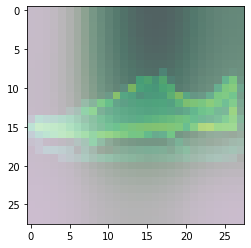

Predicted Class = 7, Probability = 0.99914956


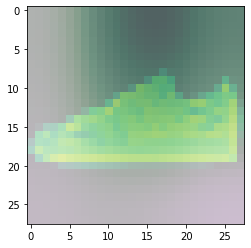

Predicted Class = 7, Probability = 0.999605


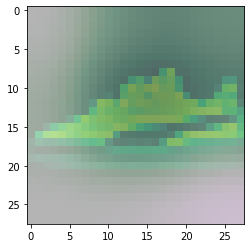

Predicted Class = 7, Probability = 0.9948997


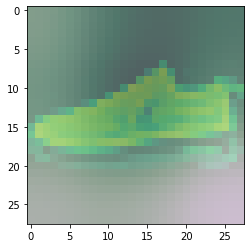

Predicted Class = 7, Probability = 0.82105875


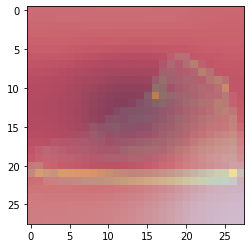

Predicted Class = 7, Probability = 0.9981652


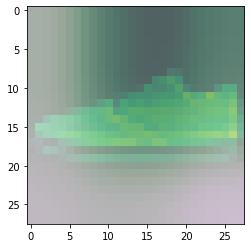

Predicted Class = 7, Probability = 0.96117395


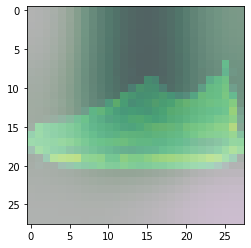

Predicted Class = 7, Probability = 0.9312185


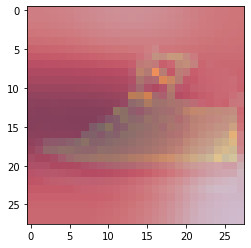

Predicted Class = 7, Probability = 0.98731124


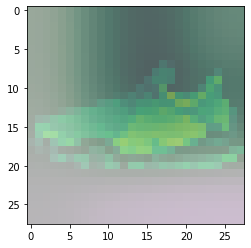

Predicted Class = 7, Probability = 0.99816906


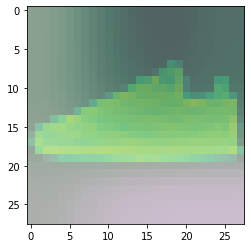

Predicted Class = 7, Probability = 0.99943596


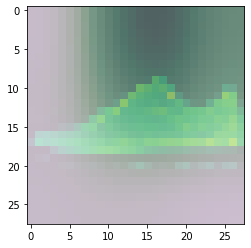

Predicted Class = 7, Probability = 0.99928254


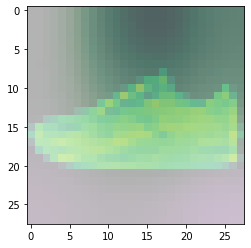

Predicted Class = 7, Probability = 0.57235026


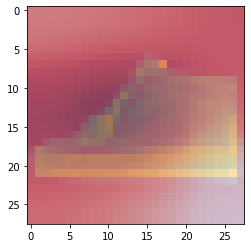

Predicted Class = 7, Probability = 0.99938786


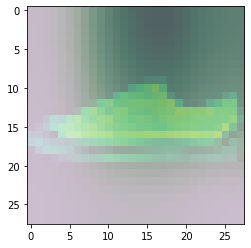

Predicted Class = 7, Probability = 0.93195105


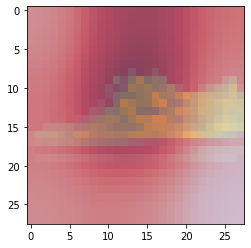

Predicted Class = 7, Probability = 0.99041337


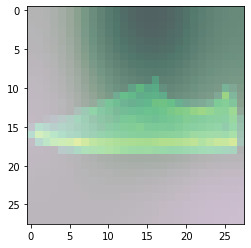

Predicted Class = 7, Probability = 0.9926369


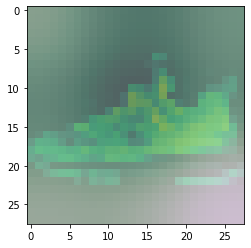

Predicted Class = 7, Probability = 0.71883535


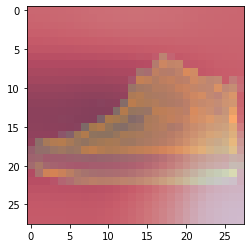

Predicted Class = 7, Probability = 0.99949276


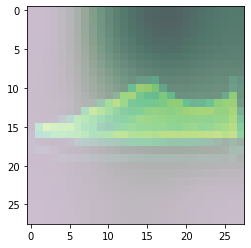

Predicted Class = 7, Probability = 0.9977329


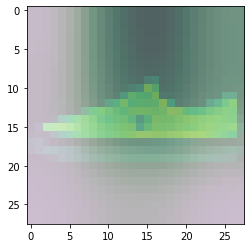

In [17]:
show_maps(desired_class=7, num_maps=20)